In [1]:
# 04_modeling.ipynb
import pandas as pd, os, joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

df = pd.read_csv("../data/processed/features.csv")
X = df.drop(columns=["cooler_pct","valve_pct","pump_leak","acc_pressure"])
y = df[["cooler_pct","valve_pct","pump_leak","acc_pressure"]]

results = {}
for target in y.columns:
    X_tr, X_val, y_tr, y_val = train_test_split(
        X, y[target], stratify=y[target], test_size=0.2, random_state=42
    )
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_tr, y_tr)
    preds = clf.predict(X_val)
    report = classification_report(y_val, preds, output_dict=True)
    results[target] = report
    print(f"\n--- {target} ---")
    print(classification_report(y_val, preds))
    # save model
    os.makedirs("../artifacts", exist_ok=True)
    joblib.dump(clf, f"../artifacts/{target}_rf.pkl")

# Optional: assemble a summary table
import pandas as pd
summary = pd.DataFrame({
    t: {"accuracy": results[t]["accuracy"],
        **{f"{cls}_f1": results[t][cls]["f1-score"]
           for cls in results[t] if cls not in ["accuracy","macro avg","weighted avg"]}}
    for t in results
}).T
summary.to_csv("../artifacts/model_performance.csv")
print("\nSaved performance summary to artifacts/model_performance.csv")
summary



--- cooler_pct ---
              precision    recall  f1-score   support

           3       1.00      1.00      1.00       147
          20       1.00      1.00      1.00       146
         100       1.00      1.00      1.00       148

    accuracy                           1.00       441
   macro avg       1.00      1.00      1.00       441
weighted avg       1.00      1.00      1.00       441


--- valve_pct ---
              precision    recall  f1-score   support

          73       0.99      1.00      0.99        72
          80       0.96      0.97      0.97        72
          90       0.95      0.96      0.95        72
         100       1.00      0.98      0.99       225

    accuracy                           0.98       441
   macro avg       0.97      0.98      0.97       441
weighted avg       0.98      0.98      0.98       441


--- pump_leak ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       244
           1     

,accuracy,3_f1,20_f1,100_f1,73_f1,80_f1,90_f1,0_f1,1_f1,2_f1,115_f1,130_f1
cooler_pct,1.000000,1.0,1.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
valve_pct,0.979592,NaN,NaN,0.988814,0.993103,0.965517,0.951724,NaN,NaN,NaN,NaN,NaN
pump_leak,0.995465,NaN,NaN,NaN,NaN,NaN,NaN,0.997947,0.994924,0.989899,NaN,NaN
acc_pressure,0.968254,NaN,NaN,0.955414,NaN,NaN,0.984520,NaN,NaN,NaN,0.931677,0.979253



===== Cross‑val for cooler_pct =====
Accuracy:   0.998 ± 0.001
F1 (macro): 0.998 ± 0.001

===== Cross‑val for valve_pct =====
Accuracy:   0.987 ± 0.006
F1 (macro): 0.984 ± 0.008

===== Cross‑val for pump_leak =====
Accuracy:   0.995 ± 0.003
F1 (macro): 0.993 ± 0.004

===== Cross‑val for acc_pressure =====
Accuracy:   0.985 ± 0.004
F1 (macro): 0.982 ± 0.005

===== Confusion Matrices on 80/20 split =====


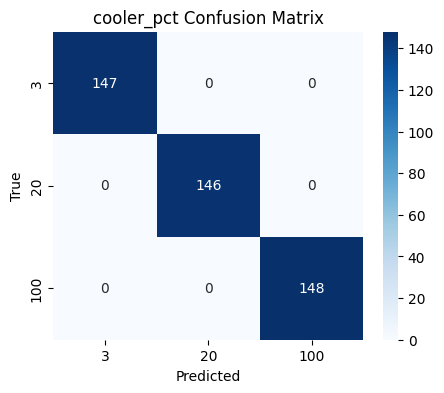

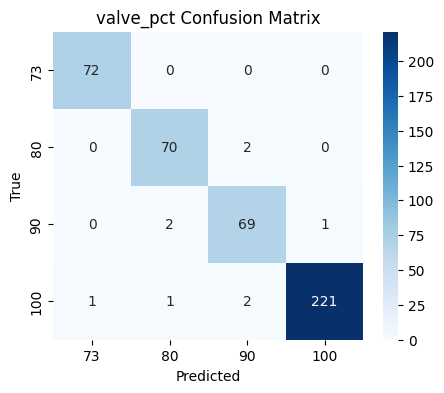

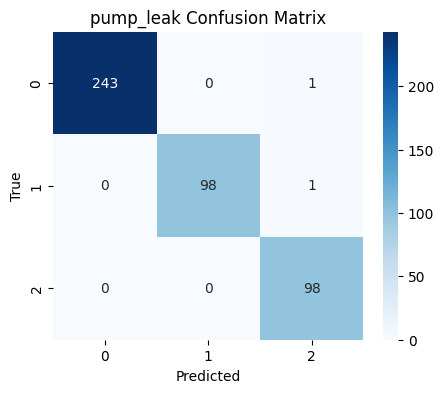

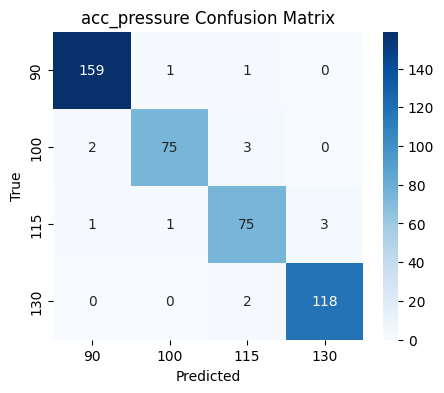


===== Inference Speed =====
cooler_pct: 0.104 ms/sample over 441 samples
valve_pct: 0.062 ms/sample over 441 samples
pump_leak: 0.085 ms/sample over 441 samples
acc_pressure: 0.066 ms/sample over 441 samples


In [3]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble     import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.metrics      import make_scorer, accuracy_score, f1_score, confusion_matrix

# 1) Load data
df = pd.read_csv("../data/processed/features.csv")
feature_cols = [c for c in df.columns 
                if c not in ["cooler_pct","valve_pct","pump_leak","acc_pressure"]]

X = df[feature_cols].values
targets = {
    "cooler_pct":   df["cooler_pct"].values,
    "valve_pct":    df["valve_pct"].values,
    "pump_leak":    df["pump_leak"].values,
    "acc_pressure": df["acc_pressure"].values
}

# 2) Setup CV and scoring
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    "accuracy":   make_scorer(accuracy_score),
    "f1_macro":   make_scorer(f1_score, average="macro")
}

results = {}

for name, y in targets.items():
    print(f"\n===== Cross‑val for {name} =====")
    clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    cv_res = cross_validate(clf, X, y, cv=cv, scoring=scoring)
    
    acc_mean = cv_res["test_accuracy"].mean()
    acc_std  = cv_res["test_accuracy"].std()
    f1_mean  = cv_res["test_f1_macro"].mean()
    f1_std   = cv_res["test_f1_macro"].std()
    
    print(f"Accuracy:   {acc_mean:.3f} ± {acc_std:.3f}")
    print(f"F1 (macro): {f1_mean:.3f} ± {f1_std:.3f}")
    
    results[name] = (acc_mean, f1_mean)

# 3) Train on a single train/test split and show confusion matrix
print("\n===== Confusion Matrices on 80/20 split =====")
for name, y in targets.items():
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )
    clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    clf.fit(X_tr, y_tr)
    preds = clf.predict(X_te)
    
    cm = confusion_matrix(y_te, preds, labels=np.unique(y))
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# 4) Measure inference time
print("\n===== Inference Speed =====")
for name, y in targets.items():
    X_tr, X_te, y_tr, y_te = train_test_split(
        X, y, stratify=y, test_size=0.2, random_state=42
    )
    clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    clf.fit(X_tr, y_tr)
    
    # Warm‑up
    _ = clf.predict(X_te[:100])
    
    start = time.time()
    _ = clf.predict(X_te)
    end   = time.time()
    total = (end - start) * 1000  # ms
    per_sample = total / len(X_te)
    
    print(f"{name}: {per_sample:.3f} ms/sample over {len(X_te)} samples")
